Here we try and replicate the oscillator that models Covid cases described in the Linka et al paper

In [1]:
# We import the necessary libraries
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Set data type
DTYPE='float32'
tf.keras.backend.set_floatx(DTYPE)

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# world-wide COVID cases, daily, since start of pandemic
covid_world = np.loadtxt('covid_world.dat')

# make time array
days = np.arange(0,covid_world.shape[0])
years = days/365

def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

# smooth data to take out weekly fluctuations due to reporting
covid_world_smooth = movingaverage(covid_world[:,1],7)


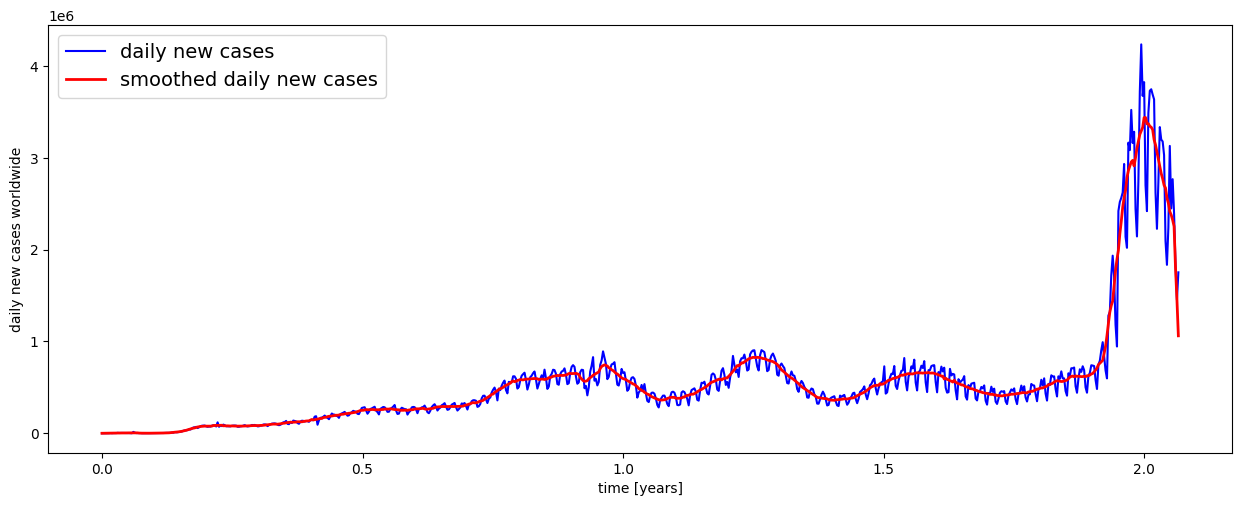

In [3]:
# plot data
plt.figure(figsize=(1100/72,400/72))
plt.plot(years,covid_world[:,1],color='blue',label='daily new cases')
plt.plot(years,covid_world_smooth,linewidth=2.0,color='red', label='smoothed daily new cases')
plt.xlabel('time [years]')
plt.ylabel('daily new cases worldwide')
plt.legend(loc='upper left',fontsize=14)

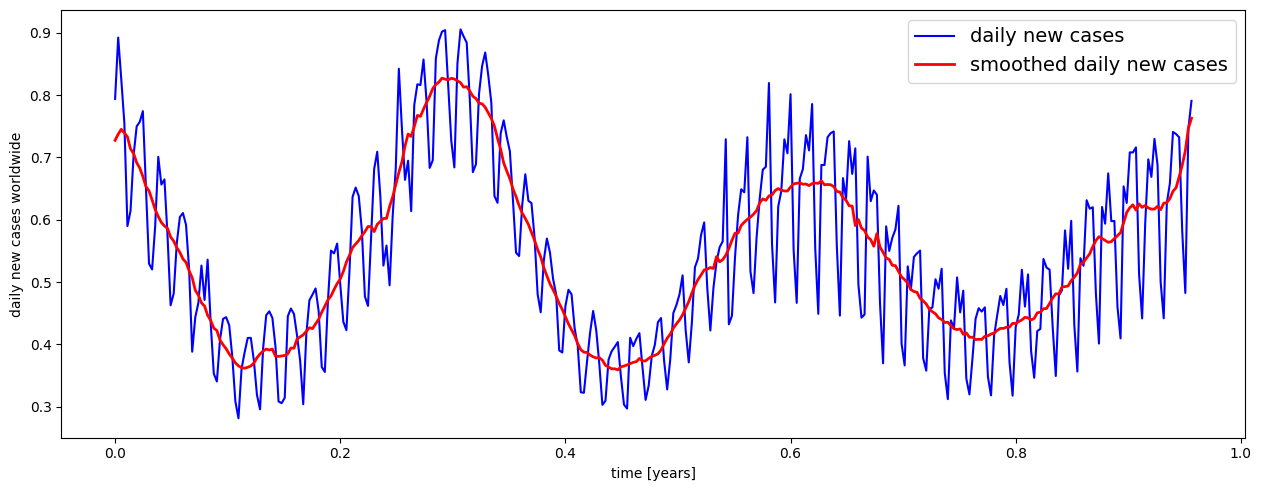

In [4]:
# select time window of interest
d1 = 350
d2 = 700

# plot data in window of interest (normalize case numbers by 10^6)
plt.figure(figsize=(1100/72,400/72))
plt.plot((days[d1:d2]-d1)/365,covid_world[d1:d2,1]/1e06,color='blue',label='daily new cases')
plt.plot((days[d1:d2]-d1)/365,covid_world_smooth[d1:d2]/1e06,linewidth=2.0,color='red', label='smoothed daily new cases')
plt.xlabel('time [years]')
plt.ylabel('daily new cases worldwide')
plt.legend(loc='upper right',fontsize=14)

In [5]:
# We define a time domain
geom = dde.geometry.TimeDomain(0, 225)

In [6]:
#### create training data arrays
t_covid = days[d1:d2]-d1   # time array: days
y_covid = t_covid/365      # time array: years

x_covid = covid_world_smooth[d1:d2]/1e06  # normalize COVID numbers per 10^6 people

# pick range of training data
t_data = y_covid[0:225:1]
x_data = x_covid[0:225:1]

# collocation points for enforcing ODE (whole window of interest)
t_physics = y_covid[0::1]

In [7]:
# weighting factor for losses : (1-eps)*loss_data + eps*loss_r
eps = 1e-3

In [8]:
# Our aim is to find the 2 unknown variables (c, k and x0) for the system of equations.
c = dde.Variable(2.2) # c = viscous damping coefficient
k = dde.Variable(350.) # k = stiffness
x0 = dde.Variable(0.56) # x0 = offset
# We initialize them to the same value that they were initialized in the paper

In [9]:
# We express the residual of the ODE
def ode(t, y):
    dy_dt = dde.grad.jacobian(y, t)
    d2y_dt2 = dde.grad.hessian(y, t)
    return d2y_dt2 + c * dy_dt + k * (y - x0)

In [10]:
# Define the initial condition y(0) = -1
ic1 = dde.icbc.IC(geom, lambda x: x0, lambda _, on_initial: on_initial)

In [11]:
# Now we want to define the initial condition y'(0) = 2
def boundary_l(t, on_boundary):
    return on_boundary and dde.utils.isclose(t[0], 0)

def error_2(inputs, outputs, X):
    return dde.grad.jacobian(outputs, inputs, i=0, j=None) - x0

ic2 = dde.icbc.OperatorBC(geom, error_2, boundary_l)

### COME BACK TO THIS

In [12]:
observe_t = t_data
ob_y = x_data
observe_t = observe_t.reshape(225, 1)
ob_y = ob_y.reshape(225,1)
observe_y = dde.icbc.PointSetBC(observe_t, ob_y[:, 0:1], component=0)

In [13]:
# We define the PDE problem
data = dde.data.PDE(geom, ode, [ic1, ic2, observe_y], num_domain=3600,
    num_boundary=2, anchors=observe_t, num_test=500)

In [14]:
# We define the network
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [15]:
external_trainable_variables = [c,k,x0]

variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

Compiling model...
Building feed-forward neural network...
'build' took 0.018891 s

'compile' took 0.132827 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [2.04e+04, 3.14e-01, 2.32e-01, 2.95e-01]    [1.95e+04, 3.14e-01, 2.32e-01, 2.95e-01]    []  


/Users/giuliadesanctis/PycharmProjects/compStat/venv/lib/python3.11/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2024-03-11 00:09:17.711442: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


1000      [2.66e-01, 8.30e-05, 2.56e-01, 2.01e-02]    [1.41e-01, 8.30e-05, 2.56e-01, 2.01e-02]    []  
2000      [3.72e-02, 1.81e-05, 2.74e-01, 2.01e-02]    [1.49e-02, 1.81e-05, 2.74e-01, 2.01e-02]    []  
3000      [5.57e-02, 1.67e-05, 2.73e-01, 2.01e-02]    [3.94e-02, 1.67e-05, 2.73e-01, 2.01e-02]    []  
4000      [2.24e-02, 1.20e-05, 2.74e-01, 2.01e-02]    [9.67e-03, 1.20e-05, 2.74e-01, 2.01e-02]    []  
5000      [3.01e-02, 1.37e-05, 2.70e-01, 2.01e-02]    [1.58e-02, 1.37e-05, 2.70e-01, 2.01e-02]    []  
6000      [1.64e-02, 1.11e-05, 2.70e-01, 2.01e-02]    [6.00e-03, 1.11e-05, 2.70e-01, 2.01e-02]    []  
7000      [1.66e-02, 1.21e-05, 2.66e-01, 2.01e-02]    [5.61e-03, 1.21e-05, 2.66e-01, 2.01e-02]    []  
8000      [2.34e-02, 1.43e-05, 2.61e-01, 2.01e-02]    [1.15e-02, 1.43e-05, 2.61e-01, 2.01e-02]    []  
9000      [2.65e+00, 1.99e-05, 2.62e-01, 2.01e-02]    [2.80e+00, 1.99e-05, 2.62e-01, 2.01e-02]    []  
10000     [1.73e-02, 1.38e-05, 2.54e-01, 2.01e-02]    [5.68e-03, 1.38e-05

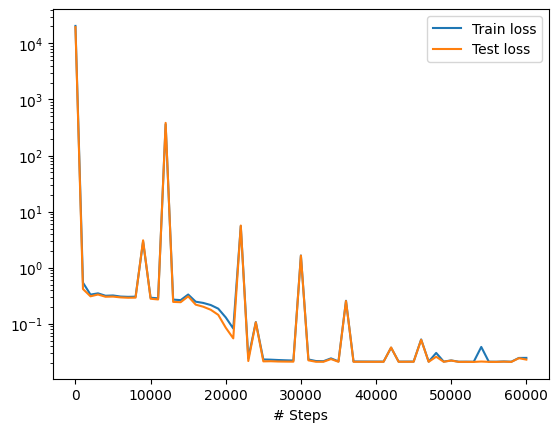

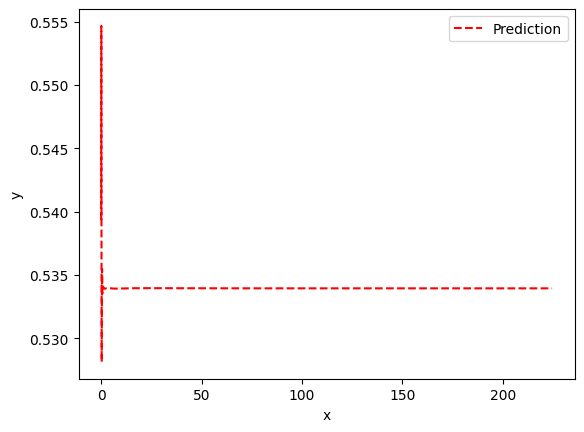

In [16]:
# Create the model
model = dde.Model(data, net)
model.compile("adam", lr=.001, external_trainable_variables=external_trainable_variables)
losshistory, train_state = model.train(iterations=60000, callbacks=[variable])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)